## Домашнее задание № 3
 Коллаборативная фильтрация

### Теоретическая часть

#### № 1

##### Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. 

**User-User** - рекомендации товаров выбраных(или точнее купленых)похожими между собой пользователями (т.е. со схожими характеристиками: возраст, семейное положение, регион проживания и прочее). 

**Item-Item** - рекомендации для пользователей, используя для рекомендации товары подобные интересующих пользователя (например, на основе покупок таких же товаров другими пользователями или товаров из этой же группы (зубная щетка-паста для зубов). 

##### Чем они отличаются и чем они похожи?  

Они похожи способом получения рекомендаций - из матрицы user - item создается матрица **User-User** (где на пересечении будут метрики отмечающие взаимодействия по сходным товарам) или **Item-Item** (на пересечении будут взаимодействия по сходным пользователям). 
А различие в том, что в случае **User-User** мы находим похожих пользователей, а в **Item-Item** - товары

##### Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?

Да, если транспорнировать матрицу так, чтобы по строкам получись юзеры (User), а по столбцам - товары (Item).

##### В чем принципиальные отличия item-item рекомендаций от ALS?

В **Item-Item** мы используем KNN, а в ALS матричное разложение и матрицы ембедингов юзеров и товаров. 
В ALS учитывается если пользователь не имел взаимодействия с товаром, в **Item-Item** учитываются только кейсы взаимодействия. 
В ALS мы используем разложение матрицы на матрицу факторов юзеров и матрицу факторов товаров, а в KNN - используем ее всю. Это позволяет выиграть в скорости 



#### № 2

##### Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров

1. срок службы купленного ранее товара (например, был куплен шампунь, через месяц предложить его же или подобный ему товар (новинку))
2. товары, положенные в корзину, но не купленные (забытые в корзине)
3. товары из той же группы, что были купленны ранее (краски-кисти, карандаш-ластик, телефон-чехол и т.п.)

#### № 3

##### Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

ALS не учитывает все фичи юзеров и товаров, например такие как пол или сезонность (за исключением случаев, когда по ним было проведено взвешивание), На вход принимает только *позитивные* взаимодействия, Прогнозирует **не** вероятность, а некоторые числа, В ALS нельзя добавить внешние фичи

Для разложения User-Item матрицы на матрицы эмбедингов юзеров и товаров необходимо, чтобы каждый пользователь сделал хотя бы одну покупку или чтобы каждый товар купили хотя бы один раз

### Практическая часть

In [2]:
pip install implicit

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

In [5]:
data = pd.read_csv('/Users/ekaterina/Desktop/LEARN/IT/Рекомендательные системы/retail_train 2.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/Users/ekaterina/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
def precision(recommended_list, 
               bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)
    
def precision_at_k(recommended_list, 
                    bought_list, 
                    k=5):
    return precision(recommended_list[:k], bought_list)

def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],
                                    #filter_items=None, 
                                    recalculate_user=True)]
    return res

def ALS_tester(user_item_matrix, name_of_column):
    model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    use_gpu=False) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

    result[name_of_column] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

def test_the_idea (name_of_column, name_of_func, fill_value=0):
    global user_item_matrix
    global sparse_user_item
    global id_to_itemid
    global id_to_userid
    global itemid_to_id
    global userid_to_id
    
    user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc=name_of_func, 
                                  fill_value=fill_value
                                 )
    

    fill_value
    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()# переведем в формат saprse matrix
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values
    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))
    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))
    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
        
    ALS_tester(user_item_matrix, name_of_column)

#### Подбор матрицы  cui 
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных  C . В качестве результата приведите таблицу: матрица весов - результат на train и validation. Сделате качественные выводы.

In [10]:
test_the_idea('mean','mean')

In [11]:
test_the_idea('nunique','nunique')

In [12]:
test_the_idea('size', 'size')

In [13]:
test_the_idea('max','max')

In [14]:
test_the_idea('count', 'count' )

In [15]:
df = pd.DataFrame(columns=['aggfunc', 'presision_at_k'])
i = 0
for column in result.columns[2:]:
    presision = round(result.apply(lambda row: precision_at_k(row[column], row['actual']), axis=1).mean(), 5)
    df.loc[i] = [column, presision]
    i += 1

df.sort_values(by='presision_at_k', ascending=False)

,aggfunc,presision_at_k
1,nunique,0.20313
0,mean,0.18825
3,max,0.18688
4,count,0.18345
2,size,0.17698


##### Сделате качественные выводы.

Cамый высокий результат даёт "nunique", потому что она косвенно показывает самые популярные товары

#### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные  λ  и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:

Значение параметра - время обучения
Значение параметра - качество train, качество validation
Сделайте качественные выводы

In [16]:
user_item_matrix = pd.pivot_table(data_train, 
                              index='user_id', columns='item_id', 
                              values='quantity', # Можно пробоват ьдругие варианты
                              aggfunc='nunique', 
                              fill_value=0
                             )
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
sparse_user_item = csr_matrix(user_item_matrix).tocsr()# переведем в формат saprse matrix
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values
matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))
id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))
itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [17]:
# проверяю на валидационном сете
valid = data_train.groupby('user_id')['item_id'].unique().reset_index()
valid.columns=['user_id', 'actual']
valid.head(2)

,user_id,actual
0,1,"[999999, 840361, 845307, 852014, 856942, 91267..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556..."


In [18]:
rers_k_test=dict()
rers_k_valid = dict()
n=1

for factors in np.linspace(20,250,5):
    for regularization in np.geomspace(0.0001,0.1,5):

        
        model = AlternatingLeastSquares(factors=int(factors), 
                                        regularization=regularization,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=8)

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),show_progress=False)
        
        # train
        result[f'fs={factors}_rg={regularization}'] = \
                        result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        k = result.apply(lambda row: precision_at_k(row[f'fs={factors}_rg={regularization}'], \
                                                            row['actual']), axis=1).mean()
        # test
        valid[f'fs={factors}_rg={regularization}'] = \
                        valid['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        k_valid = valid.apply(lambda row: precision_at_k(row[f'fs={factors}_rg={regularization}'], \
                                                            row['actual']), axis=1).mean()
        
        rers_k_test[n] = [factors, regularization, k, k_valid]
        n+=1

In [19]:
# train

In [20]:
summary = pd.DataFrame.from_dict(rers_k_test,orient='index',columns=['factors', 'regularization',"train_precision_at_k", "valid_precision_at_k"])
summary[['factors', 'regularization',"train_precision_at_k", "valid_precision_at_k"]].sort_values(by='valid_precision_at_k', ascending=False).head(10)

,factors,regularization,train_precision_at_k,valid_precision_at_k
22,250.0,0.000562,0.160333,0.967907
21,250.0,0.000100,0.160137,0.967747
23,250.0,0.003162,0.161998,0.967587
24,250.0,0.017783,0.162977,0.966467
25,250.0,0.100000,0.163075,0.965586
16,192.5,0.000100,0.172380,0.955662
17,192.5,0.000562,0.172772,0.954462
19,192.5,0.017783,0.175122,0.953661
18,192.5,0.003162,0.172870,0.953501
20,192.5,0.100000,0.174535,0.952621


 ##### лучшие гиперпараметры видны из таблицы выше
 
 Как видно из графиков регуляризация непредсказуемо влияет на качество, в то время как у факторов можно видеть оптимальные участки в районе 70

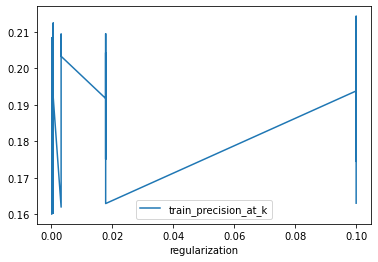

In [21]:
summary.sort_values(by='regularization').plot(x ='regularization', y='train_precision_at_k', kind = 'line')
plt.show()

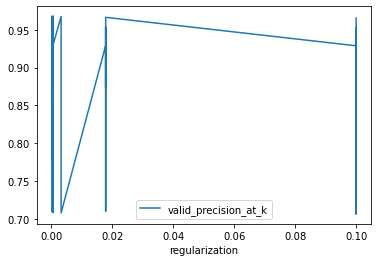

In [22]:
summary.sort_values(by='regularization').plot(x ='regularization', y='valid_precision_at_k', kind = 'line')
plt.show()

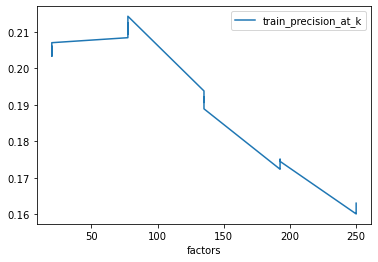

In [23]:
summary.sort_values(by='factors').plot(x ='factors', y='train_precision_at_k', kind = 'line')
plt.show()

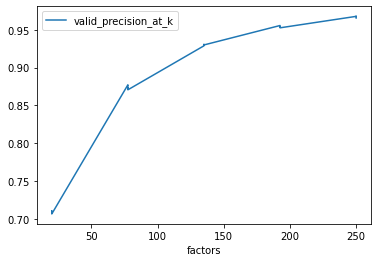

In [24]:
summary.sort_values(by='factors').plot(x ='factors', y='valid_precision_at_k', kind = 'line')
plt.show()